Process is described in methods under ViT


Code sources: <br>
https://huggingface.co/docs/transformers/en/tasks/image_classification
<br>
https://huggingface.co/blog/fine-tune-vit
<br>
https://medium.com/@imabhi1216/fine-tuning-a-vision-transformer-vit-model-with-a-custom-dataset-37840e4e9268

In [2]:
import pandas
import tensorflow as tf
from datasets import load_dataset
import itertools
import matplotlib.pyplot as plt
from PIL import Image
import torch

torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\Menee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

### Load dataset and preprocessing

In [3]:
pandasdf = pandas.read_csv('labels.csv')
print(pandasdf.shape)
pandasdf = pandasdf.drop(columns=['Type', 'Merk'])
unique_soort = pandasdf['Soort'].unique()
unique_grondstof = pandasdf['Grondstof'].unique()
# Classes are tuples; lets see how many we have
combinations = list(itertools.product(unique_soort, unique_grondstof))
combination_counts = {}
actual_classes = []
for soort, grondstof in combinations:
    count = pandasdf[(pandasdf['Soort'] == soort) & (pandasdf['Grondstof'] == grondstof)].shape[0]
    # Only include classes if we have more than 249 samples
    if count > 249:
        combination_counts[(soort, grondstof)] = count
        actual_classes.append((soort, grondstof))

# We filter the dataframe to only include saturated classes
filtered_pandasdf = pandasdf[pandasdf.apply(lambda row: (row['Soort'], row['Grondstof']) in actual_classes, axis=1)]
print(filtered_pandasdf.shape)

(112522, 5)
(108207, 3)


In [3]:
# Put the pandas df into a datasets df
from datasets import Dataset
df = Dataset.from_pandas(filtered_pandasdf)

In [4]:
def map_file_to_image_path(example):
    image_path = f"{example['File']}"
    image = Image.open(image_path)
    example['Image'] = image
    return example

# Add resized PIL image to dataset
ds = df.map(map_file_to_image_path) # This can take a long time since it has to open all images
ds

Map: 100%|██████████| 108207/108207 [08:47<00:00, 204.97 examples/s]


Dataset({
    features: ['File', 'Soort', 'Grondstof', '__index_level_0__', 'Image'],
    num_rows: 108207
})

In [5]:
from datasets import ClassLabel

# Create a new column 'ClassLabel' by concatenating 'Soort' and 'Grondstof'
def add_class_label(example):
    example['ClassLabel'] = f"{example['Soort']}_{example['Grondstof']}"
    return example

# Apply the function to add the 'ClassLabel' column
ds = ds.map(add_class_label)

# Define the ClassLabel feature - this will map the string labels to integers
class_labels = [f"{soort}_{grondstof}" for soort, grondstof in actual_classes]
class_label = ClassLabel(names=class_labels)

# Update the datasets with the ClassLabel feature
ds = ds.cast_column('ClassLabel', class_label)

# These are now all available labels
labels = ds.features['ClassLabel']
print(labels) # you can do .names for the names

Casting the dataset: 100%|██████████| 108207/108207 [00:00<00:00, 701388.48 examples/s]

ClassLabel(names=['Bag_Paper', 'Bag_Plastic', 'Balloon_Plastic', 'Ball_Plastic', 'Battery_Metal', 'Bikelamp_Plastic', 'Bikepart_Plastic', 'Bottlecap_Plastic', 'Bottlecap_Metal', 'Bottle_Plastic', 'Bottle_Glass', 'Bottlering_Plastic', 'Box_Cardboard', 'Breadclip_Plastic', 'Butt_Celluloseacetate', 'Can_Metal', 'Carpart_Plastic', 'Cleaningcloth_Microfibre', 'Clothes_Fabric', 'Clothespin_Plastic', 'Cloth_Fabric', 'Confetti_Plastic', 'Cup_Plastic', 'Cup_Cardboard', 'Drinkcarton_Plastic', 'drinkcarton_Plastic', 'Drinkpouch_Plastic', 'Ducttape_Plastic', 'Edge_Plastic', 'Firework_Plastic', 'Firework_Cardboard', 'Floss_Plastic', 'Flower_Plastic', 'Flyer_Paper', 'Foil_Aluminum', 'Fork_Plastic', 'Gascharger_Metal', 'Glove_Fabric', 'Hairtie_Plastic', 'Jar_Plastic', 'Label_Plastic', 'Lid_Plastic', 'Lid_Cardboard', 'Lighter_Plastic', 'Mouthcap_Plastic', 'Napkin_Paper', 'Pack_Plastic', 'Pack_Cardboard', 'Packingpeanut_Styrofoam', 'Pencil_Plastic', 'Piece_Paper', 'Piece_Plastic', 'Piece_Metal', 'Piece

Bag_Paper


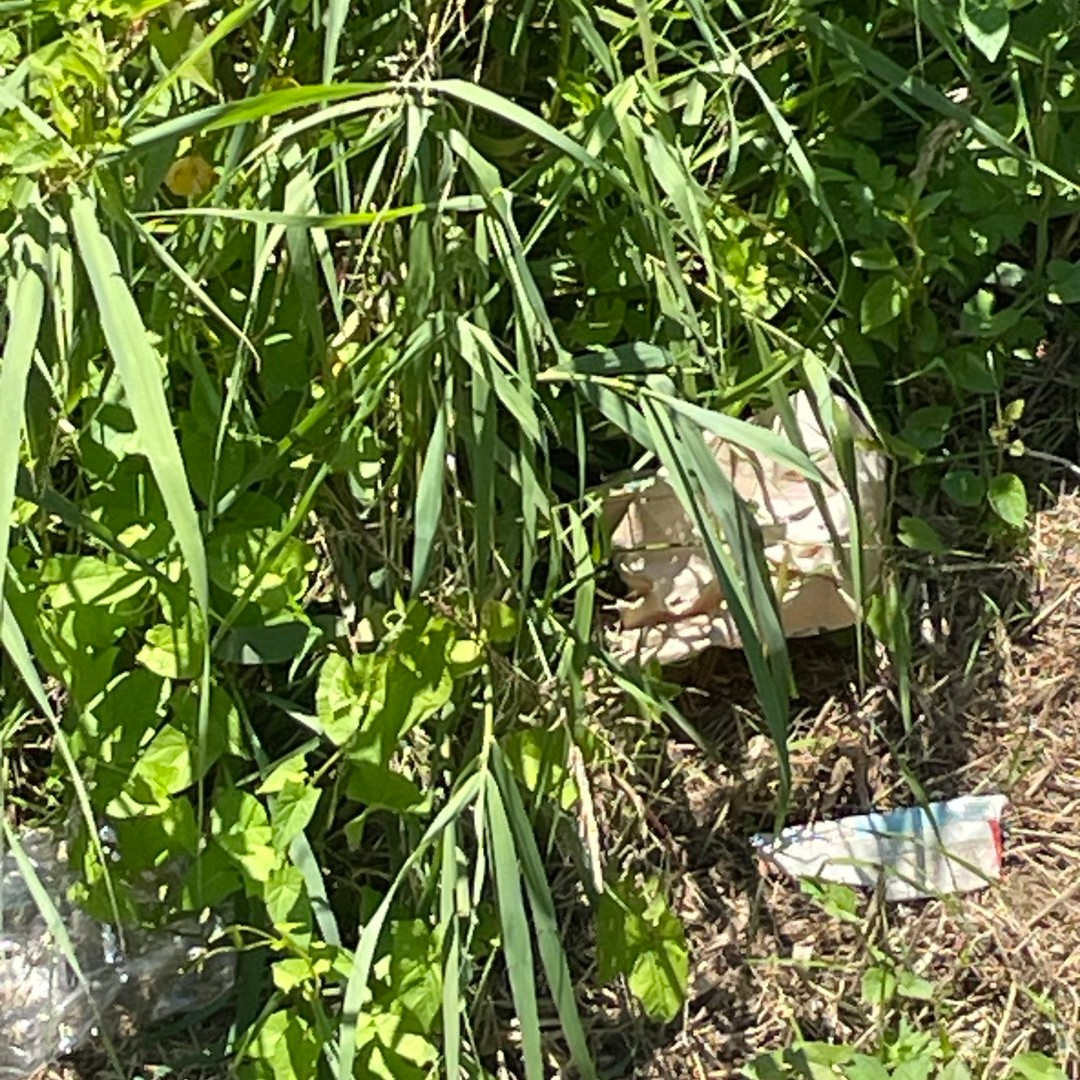

In [6]:

def showDatapoint(dp):
    # print(dp)
    print(labels.int2str(dp['ClassLabel']))
    display(dp['Image'])

ex = ds[0]
showDatapoint(ex)
# Yeah that worked

In [7]:
from datasets import DatasetDict
# We split the dataset into a training, test and validation set
ds.shuffle()
split_ds = ds.train_test_split(test_size=0.2)
train_test_ds = split_ds['train'].train_test_split(test_size=0.25)  # 0.25 * 0.8 = 0.2

dataset = DatasetDict(
    {
        "train": train_test_ds['train'],        # 0.6 
        "validation": train_test_ds['test'],    # 0.2 
        "test": split_ds['test']                # 0.2 
} 
)

### Load ViT & Processing dataset

In [8]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)


In [9]:
from torchvision.transforms import Resize, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    448, 448 #we finetune at higher resolution
)
_transforms = Compose([Resize(size), ToTensor(), normalize])

def transform(examples):
    outputs = {}
    outputs["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["Image"]]
    outputs["label"] = examples["ClassLabel"]
    return outputs


dataset = dataset.with_transform(transform)

In [10]:
# Now anytime we get it, it automatically transforms
dataset['train'][0]

{'pixel_values': tensor([[[ 0.6863,  0.6784,  0.6627,  ...,  0.2314,  0.2235,  0.2078],
          [ 0.6627,  0.6784,  0.6941,  ...,  0.1686,  0.2078,  0.2157],
          [ 0.5686,  0.6157,  0.7020,  ...,  0.0824,  0.1059,  0.1216],
          ...,
          [ 0.6549,  0.6784,  0.6392,  ..., -0.3255, -0.3490, -0.4353],
          [ 0.6706,  0.6706,  0.6706,  ..., -0.4353, -0.3020, -0.2706],
          [ 0.6627,  0.6706,  0.7098,  ..., -0.4275, -0.3882, -0.1529]],
 
         [[ 0.5294,  0.5059,  0.4588,  ...,  0.3098,  0.3098,  0.2941],
          [ 0.5059,  0.5137,  0.5059,  ...,  0.2627,  0.3020,  0.3176],
          [ 0.4275,  0.4588,  0.5216,  ...,  0.1922,  0.2157,  0.2314],
          ...,
          [ 0.3725,  0.3725,  0.3255,  ..., -0.2157, -0.2392, -0.3255],
          [ 0.3804,  0.3725,  0.3490,  ..., -0.3490, -0.2078, -0.1765],
          [ 0.3804,  0.3804,  0.3882,  ..., -0.3569, -0.3176, -0.0745]],
 
         [[ 0.3333,  0.3255,  0.3020,  ...,  0.3255,  0.3176,  0.2863],
          [ 

### Training

In [11]:
import numpy as np
import evaluate
import transformers

accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


def collate(ins):
    thedict = transformers.default_data_collator(ins)
    thedict["interpolate_pos_encoding"] = True # Allows for higher resolution input images
    return thedict

In [12]:

labelNames = labels.names
print(labelNames)

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labelNames),
    id2label={str(i): c for i, c in enumerate(labelNames)},
    label2id={c: str(i) for i, c in enumerate(labelNames)},
)



['Bag_Paper', 'Bag_Plastic', 'Balloon_Plastic', 'Ball_Plastic', 'Battery_Metal', 'Bikelamp_Plastic', 'Bikepart_Plastic', 'Bottlecap_Plastic', 'Bottlecap_Metal', 'Bottle_Plastic', 'Bottle_Glass', 'Bottlering_Plastic', 'Box_Cardboard', 'Breadclip_Plastic', 'Butt_Celluloseacetate', 'Can_Metal', 'Carpart_Plastic', 'Cleaningcloth_Microfibre', 'Clothes_Fabric', 'Clothespin_Plastic', 'Cloth_Fabric', 'Confetti_Plastic', 'Cup_Plastic', 'Cup_Cardboard', 'Drinkcarton_Plastic', 'drinkcarton_Plastic', 'Drinkpouch_Plastic', 'Ducttape_Plastic', 'Edge_Plastic', 'Firework_Plastic', 'Firework_Cardboard', 'Floss_Plastic', 'Flower_Plastic', 'Flyer_Paper', 'Foil_Aluminum', 'Fork_Plastic', 'Gascharger_Metal', 'Glove_Fabric', 'Hairtie_Plastic', 'Jar_Plastic', 'Label_Plastic', 'Lid_Plastic', 'Lid_Cardboard', 'Lighter_Plastic', 'Mouthcap_Plastic', 'Napkin_Paper', 'Pack_Plastic', 'Pack_Cardboard', 'Packingpeanut_Styrofoam', 'Pencil_Plastic', 'Piece_Paper', 'Piece_Plastic', 'Piece_Metal', 'Piece_Glass', 'Piece_C

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-448",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  eval_strategy="epoch",
  num_train_epochs=3,
  fp16=True,
  save_strategy="epoch",
  logging_steps=1000,
  learning_rate=5e-5,
  save_total_limit=5,
  remove_unused_columns=False, # This is important, since transforms only happen when it is used
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  metric_for_best_model="accuracy",
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    processing_class=image_processor,
)

In [ ]:
# Start training
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


In [20]:
# Test it on the test set
outputs = trainer.predict(dataset['test'])
trainer.save_metrics("test", outputs.metrics)
trainer.log_metrics("test", outputs.metrics)

100%|██████████| 1353/1353 [10:01<00:00,  2.25it/s]

***** test metrics *****
  test_accuracy           =     0.8439
  test_loss               =     0.6501
  test_runtime            = 0:10:01.89
  test_samples_per_second =     35.957
  test_steps_per_second   =      2.248


In [3]:
# Sandbox for inference of abritrary test image

from transformers import ViTForImageClassification, AutoImageProcessor
from PIL import Image
import torch
import random
import os

# Load the model
model = ViTForImageClassification.from_pretrained("./vit-base-output-alt-448")
image_processor = AutoImageProcessor.from_pretrained("./vit-base-output-alt-448")

# Get a random image file from the TESTDATA folder
testdata_folder = "TESTDATA"
random_image_file = random.choice(os.listdir(testdata_folder))
image_path = os.path.join(testdata_folder, random_image_file)
image = Image.open(image_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt")

# Make inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted class
predicted_class_idx = outputs.logits.argmax(-1).item()
predicted_class = labels.int2str(predicted_class_idx)

print(f"Predicted class: {predicted_class}")
display(image)

NameError: name 'labels' is not defined